# Notebook to derive and analyse a deterministic model for independent Q-learning
In this notebook I experimented with a deterministic approximation model of Q-learning on the Prisoner's Dilemma.

## Deterministic Model of independent Q-learning on the Prisoner's Dilemma 

This notebook explores a deterministic model of temporal difference learning. To derive a deterministic model, we replace random variables with their respective expected values which may depend both on the policy of the agent $i$ itself and its opponent $j$. Differing from previous used methods, instead of assuming that all Q-values get updated at each step, we take into account that in actual Temporal Difference algorithms, only the action $a^i=A^i$ chosen at time t gets updated. In the stochastic update rule this can be expressed by an Kronecker-delta:

$$ Q^i_{a^i} ( t+1 ) 
    =  Q^i_{a^i} ( t ) 
    + \alpha 
    \textcolor{blue}{\delta_{a^iA^i}}
    \left[ R^i(a^i, A^j)  
    + \gamma \max_{b^i \in \mathcal{A}^i} Q^i_{b^i}(t) 
    - Q^i_{a^i}(t) \right] 
    . $$

The old deterministic model assumed that all Q-values get updated simultaneously with their expected values under the opponents current policy:
$$ \mathbb{E}_{A^j \sim \pi^j}  Q^i_{a^i} ( t+1 ) 
    =  Q^i_{a^i} ( t ) 
    + \alpha 
    \left[ \mathbb{E}_{A^j \sim \pi^j} R^i(a^i, A^j)  
    + \gamma \max_{b^i \in \mathcal{A}^i} Q^i_{b^i}(t) 
    - Q^i_{a^i}(t) \right] 
    . $$

To account for the different update frequencies in an deterministic model of Q-Learning, we weigh the temporal difference error with the probability of choosing the respective action. In the equation, we replace the Kronecker-delta in the stochastic update rule with the probability $\textcolor{blue}{\pi^i_{a^i}(t)}$:

$$ \mathbb{E}_{\underline A \sim \underline \pi}  Q^i_{a^i} ( t+1 ) 
    =  Q^i_{a^i} ( t ) 
    + \alpha 
    \textcolor{blue}{\pi^i_{a^i}(t)}
    \left[ \mathbb{E}_{A^j \sim \pi^j} R^i(a^i, A^j)  
    + \gamma \max_{b^i \in \mathcal{A}^i} Q^i_{b^i}(t) 
    - Q^i_{a^i}(t) \right] 
    . $$
    


In [1]:
# import general libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection
# from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.optimize import fsolve

In [2]:
class DeterministicAgent():
    def __init__(self, Q_values_initial, learning_rate, discount_factor, temperature):
        self.Q_values_initial = Q_values_initial
        self.Q_values = Q_values_initial
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.temperature = temperature
        self.Q_values_history = []         # history of Q-values
        self.prob_vector_history = []        # history of probabilities

    def get_prob_vector(self):
        return np.exp(self.Q_values / self.temperature) / np.sum(np.exp(self.Q_values / self.temperature))
    
    def update_history(self):
        self.Q_values_history.append(self.Q_values)
        self.prob_vector_history.append(self.get_prob_vector())

    def reset(self):
        self.Q_values = self.Q_values_initial

def Q_step(agents, reward_matrices):
    '''Deterministic Q-learning step for a symmetric 2x2 repeated normal-form game for two agents'''
    # update history
    for agent in agents:
        agent.update_history()

    # get the probability vector of the agents
    agent_1, agent_2 = agents
    prob_vector_agent_1 = agent_1.get_prob_vector()
    prob_vector_agent_2 = agent_2.get_prob_vector()

    # get the reward matrices
    reward_matrix_A, reward_matrix_B = reward_matrices
    
    # update the Q-values via deterministic equation
    Q_vector_new_1 = agent_1.Q_values + agent_1.learning_rate * prob_vector_agent_1 * (reward_matrix_A @ prob_vector_agent_2 + agent_1.discount_factor * np.max(agent_1.Q_values) - agent_1.Q_values)
    Q_vector_new_2 = agent_2.Q_values + agent_2.learning_rate * prob_vector_agent_2 * (prob_vector_agent_1 @ reward_matrix_B + agent_2.discount_factor * np.max(agent_2.Q_values) - agent_2.Q_values)

    # update the Q-values
    agent_1.Q_values = Q_vector_new_1
    agent_2.Q_values = Q_vector_new_2

def generate_q_values(prob_to_coop, temperature, base_value):
    # Calculate the difference between Q-values
    delta_Q = temperature * np.log(1/prob_to_coop - 1) # difference between Q-values: delta_Q = Q_D - Q_C
    
    # Calculate Q_D and Q_C centered around the base value
    Q_D = base_value + delta_Q / 2
    Q_C = base_value - delta_Q / 2
    
    return np.array([Q_C, Q_D])

# define the reward function for the two player prisoner's dilemma
def reward_matrix_for_two_player_PD(action_vector, player_id):
    action_tuple = tuple(action_vector)
    S, P, R, T = 0, 1, 3, 5
    #S, P, R, T = -44.05, -41.04, 3.01, 6.37
    reward_matrix = {
            (0, 0): (R, R),  # Both cooperate
            (0, 1): (S, T),  # Agent A cooperates, agent B defects
            (1, 0): (T, S),  # Agent A defects, agent B cooperates
            (1, 1): (P, P),  # Both defect
        }
    reward = reward_matrix[action_tuple]
    return reward[player_id]

# define the reward function for the two player prisoner's dilemma
def reward_matrix_for_two_player_MP(action_vector, player_id):
    action_tuple = tuple(action_vector)
    W, L = 1, -1
    reward_matrix = {
            (0, 0): (W, L),  
            (0, 1): (L, W),  
            (1, 0): (L, W),  
            (1, 1): (W, L),  
        }
    reward = reward_matrix[action_tuple]
    return reward[player_id]

# define the reward function for the two player battle of sexes
def reward_matrix_for_two_player_SH(action_vector, player_id):
    action_tuple = tuple(action_vector)
    reward_matrix = {
            (0, 0): (4, 4),  # Both defect
            (0, 1): (1, 3),  # Agent A defects, agent B cooperates
            (1, 0): (3, 1),  # Agent A cooperates, agent B defects
            (1, 1): (3, 3),  # Both cooperate
        }
    reward = reward_matrix[action_tuple]
    return reward[player_id]

# define the reward function for the two player battle of sexes
def reward_matrix_for_two_player_BS(action_vector, player_id):
    action_tuple = tuple(action_vector)
    reward_matrix = {
            (0, 0): (3, 2),  # Both defect
            (0, 1): (0, 0),  # Agent A defects, agent B cooperates
            (1, 0): (0, 0),  # Agent A cooperates, agent B defects
            (1, 1): (2, 3),  # Both cooperate
        }
    reward = reward_matrix[action_tuple]
    return reward[player_id]

# Extract the individual reward matrices for the two player games individually for vectorized calculations
def get_individual_matrices(reward_function):
    # extract the individual reward matrices
    reward_matrix_A = np.array([[reward_function([0, 0], 0), reward_function([0, 1], 0)],
                                [reward_function([1, 0], 0), reward_function([1, 1], 0)]])
    reward_matrix_B = np.array([[reward_function([0, 0], 1), reward_function([0, 1], 1)],
                                [reward_function([1, 0], 1), reward_function([1, 1], 1)]])
    
    if reward_function == reward_matrix_for_two_player_PD:
        game_title = 'Prisoner\'s Dilemma'
        first_action_title = 'Cooperation'
    elif reward_function == reward_matrix_for_two_player_MP:
        game_title = 'Matching Pennies'
        first_action_title = 'Heads'
    elif reward_function == reward_matrix_for_two_player_SH:
        game_title = 'Stag Hunt'
        first_action_title = 'Stag'
    elif reward_function == reward_matrix_for_two_player_BS:
        game_title = 'Bach or Stravinsky'
        first_action_title = 'Bach'

    return [reward_matrix_A, reward_matrix_B], game_title, first_action_title

# define the function that calculates the fixed point policy for the prisoner's dilemma
def calculate_fixed_point_policy(temperature, discount_factor, initial_guess = [0, 1], print_solution = True, print_additional_info = False):
    # define four-dimensional system of equations
    def equations(variables, T = temperature, discount_factor = discount_factor):
        a, b, c, d = variables

        eq1 = a - 1 / (np.exp(c/T) + np.exp(d/T)) * (3 * np.exp(c/T)) +\
            discount_factor * max(a,b)
        eq2 = b - 1 / (np.exp(c/T) + np.exp(d/T)) * (5 * np.exp(c/T) + np.exp(d/T)) +\
            discount_factor * max(a,b)
        eq3 = c - 1 / (np.exp(a/T) + np.exp(b/T)) * (3 * np.exp(a/T)) +\
            discount_factor * max(c,d)
        eq4 = d - 1 / (np.exp(a/T) + np.exp(b/T)) * (5 * np.exp(a/T) + np.exp(b/T)) +\
            discount_factor * max(c,d)

        return [eq1, eq2, eq3, eq4]

    # Initial guess for the solution
    a_init, b_init = initial_guess
    initial_guess = [a_init, b_init, a_init, b_init]

    # Solve the system numerically and get information
    result, infodict, ier, msg = fsolve(equations, initial_guess, full_output=True)
    a, b, c, d = result
    fixed_point_policy = np.exp(a/temperature) / (np.exp(a/temperature) + np.exp(b/temperature))

    # prints
    if print_solution:
        print("------------------------------------")
        print(f"Numerical Solution: Q^1_C = {a}, Q^1_D = {b}, Q^2_C = {c}, Q^2_D = {d}")
        print("Q^1_D - Q^1_C =", b - a)
        print(f"Fixed point policy at T={temperature} : ", fixed_point_policy)
        print("------------------------------------")
        print()


    if print_additional_info:
        # Additional information about the solution process
        print("\nSolution Process Information:")
        print("Number of iterations:", infodict['nfev'])
        print("fjac\n", infodict['fjac'])
        print("fvec\n", infodict['fvec'])
        print("r", infodict['r'])
        print("qtf", infodict['qtf'])
        print("Exit code:", ier)
        print("Exit message:", msg)

        # Zustandssumme: 
        N1 = np.exp(result[0]) + np.exp(result[1])
        N2 = np.exp(result[2]) + np.exp(result[3])
        print()
        print("Zustandssumme:")
        print("N1 =", N1)
        print("N2 =", N2)

        # Wahrscheinlichkeiten:
        print("Wahrscheinlichkeiten:")
        print("p1 =", np.exp(result[0]) / N1)
        print("p2 =", np.exp(result[1]) / N1)

    return fixed_point_policy

# define the function that calculates the Q target values for a given opponents policy for the prisoner's dilemma
def calculate_target_Q_values(prob_to_coop_j, discount_factor, print_solution = False):
    # expected rewards for agent i
    Exp_Reward_C = 3 * prob_to_coop_j + 0 * (1. - prob_to_coop_j)
    Exp_Reward_D = 5 * prob_to_coop_j + 1 * (1. - prob_to_coop_j)

    # geometric series for agent i
    Q_max_C = Exp_Reward_C / (1 - discount_factor)
    Q_max_D = Exp_Reward_D / (1 - discount_factor)

    # target Q-values for agent j
    Q_target_C = Exp_Reward_C + discount_factor * max(Q_max_C, Q_max_D)
    Q_target_D = Exp_Reward_D + discount_factor * max(Q_max_C, Q_max_D)

    if print_solution:
        print("------------------------------------")
        print(f"For prob_to_coop_j = {prob_to_coop_j} and discount_factor = {discount_factor}, the target Q-values are:")
        print(f"Q_target_C = {Q_target_C}")
        print(f"Q_target_D = {Q_target_D}")
        print("------------------------------------")
        print()

    return np.array([Q_target_C, Q_target_D])

# write a function that calculates the eigenvalues and eigenvectors of the Jacobi matrix for the Prisoner's Dilemma
def calculate_eigenvalues_and_eigenvectors(discount_factor, temperature, learning_rate, print_solution = False):  
    # calculate the fixed point policy and the target Q-values
    fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
    Q_target_C, Q_target_D = calculate_target_Q_values(fixed_point_policy, discount_factor, print_solution = False)

    def p(a, b):
        return np.exp(a/temperature) / (np.exp(a/temperature) + np.exp(b/temperature))

    def partial_p(a, b):
        return np.exp((a+b)/temperature) / ( temperature * (np.exp(a/temperature) + np.exp(b/temperature))**2 )

    def f(a, b, c, d):
        return learning_rate * partial_p(a, b) * ( 3 * p(c, d) + discount_factor * b - a)

    def g(a, b, c, d):
        return 3 * learning_rate * p(a,b) * partial_p(c, d)

    def h(a, b, c, d):
        return learning_rate * partial_p(a, b) * ( 4 * p(c, d) + 1 + (discount_factor - 1) * b)

    def i(a, b, c, d):
        return 4 * learning_rate * (1 - p(a,b)) * partial_p(c, d)

    a, b, c, d = Q_target_C, Q_target_D, Q_target_C, Q_target_D

    # define the Jacobi matrix entries
    if True:
        j_11 = + f(a,b,c,d) - learning_rate * p(a, b) + 1
        j_12 = - f(a,b,c,d) + learning_rate * discount_factor * p(a, b)
        j_13 = + g(a,b,c,d)
        j_14 = - g(a,b,c,d)

        j_21 = - h(a,b,c,d)
        j_22 = + h(a,b,c,d) + learning_rate * (discount_factor - 1) * (1 - p(a, b)) + 1
        j_23 = + i(a,b,c,d)
        j_24 = - i(a,b,c,d)

        j_31 = + g(c,d,a,b)
        j_32 = - g(c,d,a,b)
        j_33 = + f(c,d,a,b) - learning_rate * p(c, d) + 1
        j_34 = - f(c,d,a,b) + learning_rate * discount_factor * p(c, d)

        j_41 = + i(c,d,a,b)
        j_42 = - i(c,d,a,b)
        j_43 = - h(c,d,a,b)
        j_44 = + h(c,d,a,b) + learning_rate * (discount_factor - 1) * (1 - p(c, d)) + 1

    # Define the 4x4 Jacobi matrix 
    J = np.array([[j_11, j_12, j_13, j_14],
                [j_21, j_22, j_23, j_24],
                [j_31, j_32, j_33, j_34],
                [j_41, j_42, j_43, j_44]])

    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(J)
    eigenvalues_betrag = np.abs(eigenvalues)

    # Print the results
    if print_solution:
        print(f"gamma = {discount_factor}")
        print()
        for i in range(len(eigenvalues)):
            print(f"Eigenvalue {i+1}:", eigenvalues[i])
        print()
        for i in range(len(eigenvalues_betrag)):
            print(f"Absolute Eigenvalue {i+1}:", eigenvalues_betrag[i])
        print()
    
    return eigenvalues, eigenvectors

## Numerical solution of equilibrium solution
The equilibrium solution of this system, where $\mathbb{E}_{\underline \pi}  Q^i_{a^i} ( t+1 ) =  Q^i_{a^i} ( t ) $, is the same as in the previous model under the assumption that all actions get simultaneously updated. 
Renaming $a, b, c, d := Q^1_C, Q^1_D, Q^2_C, Q^2_D$, we have the four equations: 

$$ a = \frac{1}{e^{c/T} + e^{d/T}} \cdot (3 \cdot e^{c/T}) +\
          \gamma \max(a,b) $$
$$ b = \frac{1}{e^{c/T} + e^{d/T}} \cdot (5 \cdot  e^{c/T} + e^{d/T}) +\
          \gamma \max(a,b) $$
$$ c = \frac{1}{e^{a/T} + e^{b/T}} \cdot (3\cdot  e^{a/T}) +\
          \gamma \max(c,d) $$
$$ d = \frac{1}{e^{a/T} + e^{b/T}} \cdot (5 \cdot  e^{a/T} + e^{b/T}) +\
          \gamma \max(c,d) $$

Solving these equations numerically always reproduces our previously found equilibrium solution $\Delta Q_*$, no matter the initial guesses. However the absolute values of $a , b, c, d$ vary. This indicates that although the dynamics cannot be reduced to a 2D system, at least its equilibrium solution is fixed in 2D policy space: 

## Target values

Since we already know the fixed point in policy space, we can use this to calculate the fixed point values in Q-space. 
We simply calculate the target values of agent i given policy of opponent j, where policy of j is the fixed point policy 0.22675...
$$ Q^i_{a*}  = \mathbb{E}_{\pi^j} \left[ R^i_a \right] + \gamma \max_{a' \in \mathcal{A}} Q^i_{a'*} $$

geometric series 
$$ \sum_{k = 0}^\infty r \gamma^k = \frac{r}{1-\gamma} $$

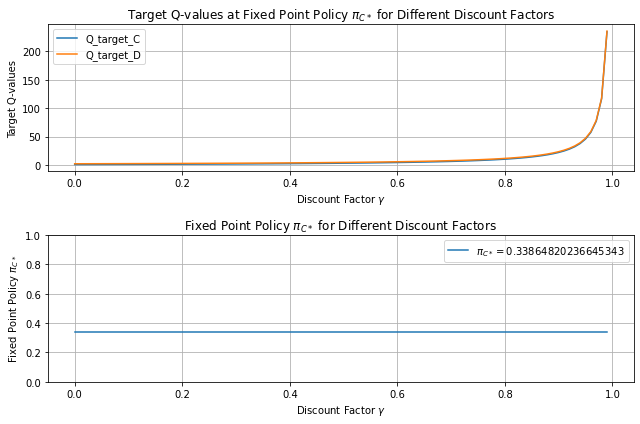

In [3]:
# enable inline plotting
%matplotlib inline

# define the temperature and discount factor
temperature = 2
discount_factor_array = np.linspace(0, 0.99, 100) # has no effect on the equilibrium solution in policy/Delta-Q space but on the absolute Q-values

# calculate the fixed point policy and target Q-values for different discount factors
fixed_point_policy_array = []
Q_target_C_array = []
Q_target_D_array = []
for discount_factor in discount_factor_array:
    fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
    Q_target_C, Q_target_D = calculate_target_Q_values(fixed_point_policy, discount_factor, print_solution = False)

    fixed_point_policy_array.append(fixed_point_policy)
    Q_target_C_array.append(Q_target_C)
    Q_target_D_array.append(Q_target_D)

if True:
    # plot the results in two subplots. One for the target Q-values and one for the fixed point policy. The discount factor is on the x-axis. 
    fig, ax = plt.subplots(2, 1, figsize=(9, 6))

    # Plot the target Q-values
    ax[0].plot(discount_factor_array, Q_target_C_array, label='Q_target_C')
    ax[0].plot(discount_factor_array, Q_target_D_array, label='Q_target_D')
    ax[0].set_xlabel(f'Discount Factor $\gamma$')
    ax[0].set_ylabel('Target Q-values')
    ax[0].set_title('Target Q-values at Fixed Point Policy $\pi_{C*} \approx 0.227$ for Different Discount Factors')
    ax[0].legend()
    ax[0].grid()
    ax[0].legend()

    # Plot the fixed point policy
    ax[1].plot(discount_factor_array, fixed_point_policy_array, label='$\pi_{C*} = $'+f'{fixed_point_policy}')
    ax[1].set_xlabel(f'Discount Factor $\gamma$')
    ax[1].set_ylabel('Fixed Point Policy $\pi_{C*}$')
    ax[1].set_title('Fixed Point Policy $\pi_{C*}$ for Different Discount Factors')
    ax[1].set_ylim(0, 1)
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()

## Stability analysis

In a 4D discrete-time dynamical system:

1. **Stability of the Fixed Point**: The fixed point is stable if all the eigenvalues $\lambda_i$ of the Jacobian matrix at the fixed point satisfy $|\lambda_i| < 1$ for all $i$.

2. **Stable Focus**: If two of the four eigenvalues are complex conjugate pairs with absolute values less than 1 (i.e., $\lambda_1, \lambda_2 = \rho e^{\pm i\theta}$ where $\rho < 1$), the fixed point is not only stable but also exhibits a "focus" behavior. This means that trajectories near the fixed point spiral towards it, rather than moving directly towards it. The complex conjugate eigenvalues indicate that the system has oscillatory dynamics in those two dimensions.

Expressing $\textcolor{blue}{\pi^i_{a^i}(t)}$ and $\mathbb{E}_{\pi^j} R^i(a^i)$ in terms of Q yields: 

$$ \mathbb{E}_{\underline A \sim \underline \pi}  Q^i_{a^i} ( t+1 ) 
    =  Q^i_{a^i} ( t ) 
    + \alpha 
    \textcolor{blue}{
        \frac{e^{Q^i_{a^i}/T}}{\sum_{b^i} e^{Q^i_{b^i}/T}}
    }
    \left [

    \frac{ e^{Q^j_{C}/T} }{ \sum_{b^j} e^{Q^j_{b^j}/T} } 
    R^i(a^i, C) 
    + \frac{ e^{Q^j_{D}/T} }{ \sum_{b^j} e^{Q^j_{b^j}/T} } 
    R^i(a^i, D)

    + \gamma \max_{b^i \in \mathcal{A}^i} Q^i_{b^i}(t) 
    - Q^i_{a^i}(t) \right] 
    . $$


In order to construct the jacobi matrix, we calculate the partial derivatives. 
To shorten the notation we rename $a, b, c, d := Q^1_C, Q^1_D, Q^2_C, Q^2_D$, and 

\begin{align}
    p_a, p_b, p_c, p_d &= \pi^1_C, \pi^1_D, \pi^2_C, \pi^2_D \\
                        &= \frac{ e^{a/T} }{ e^{a/T}+e^{b/T} }, \frac{ e^{b/T} }{ e^{a/T}+e^{b/T} }, \frac{ e^{c/T} }{ e^{c/T}+e^{d/T} }, \frac{ e^{d/T} }{ e^{c/T}+e^{d/T} }
\end{align}

Further, note that for only two actions, we can reduce 
$$ p_b = 1 - p_a $$
$$ p_d = 1 - p_c $$

This reduces the equations for the first agent to (without writing the time dependency of a,b,c,d,...): 

$$  \mathbb{E}_{\underline A \sim \underline \pi} a (t+1) = 
    a 
    + \alpha 
    p_a
    \left [
    p_c R^i(C, C) + 
    (1 - p_c) R^i(C, D)
    + \gamma \max(a,b)
    - a 
    \right] 
    . $$
$$  \mathbb{E}_{\underline A \sim \underline \pi} b (t+1) =  
    b 
    + \alpha 
    p_b
    \left [
    p_c R^i(D, C) + 
    (1 - p_c) R^i(D, D)
    + \gamma \max(a,b)
    - b 
    \right] 
    . $$

If we take into account that at the fixed point $a < b, c < d$, the max term reduces to $max(a,b) = b$ and we can take the derivative for this case:

$$  \mathbb{E}_{\underline A \sim \underline \pi} a (t+1) = 
    a 
    + \alpha 
    p_a
    \left [
    p_c R^i(C, C) + 
    (1 - p_c) R^i(C, D)
    + \gamma b
    - a 
    \right] 
    . $$
$$  \mathbb{E}_{\underline A \sim \underline \pi} b (t+1) =  
    b 
    + \alpha 
    p_b
    \left [
    p_c R^i(D, C) + 
    (1 - p_c) R^i(D, D)
    + (\gamma - 1) b
    \right] 
    . $$

If we now insert $R^i(C,C), R^i(C, D), R^i(D,C), R^i(D, D) = 3, 0, 5, 1$:

\begin{align}
\mathbb{E}_{\underline A \sim \underline \pi} a (t+1) 
    &= 
    a 
    + \alpha 
    p_a
    \left [
    3 p_c 
    + \gamma b
    - a 
    \right] 
    , \\
\mathbb{E}_{\underline A \sim \underline \pi} b (t+1) 
    &= 
    b 
    + \alpha 
    p_b
    \left [
    4 p_c 
    + 1
    + (\gamma - 1) b
    \right] 
    . \\
\mathbb{E}_{\underline A \sim \underline \pi} c (t+1) 
    &= 
    c 
    + \alpha 
    p_c
    \left [
    3 p_a 
    + \gamma d
    - c 
    \right] 
    , \\
\mathbb{E}_{\underline A \sim \underline \pi} d (t+1) 
    &= 
    d 
    + \alpha 
    p_d
    \left [
    4 p_a 
    + 1
    + (\gamma - 1) d
    \right] 
    .
\end{align}

To shorten the notation of the partial derivatives we introduce:
$$ \partial_{a} p_a = \frac{ e^{(a+b)/T} }{ T(e^{a/T}+e^{b/T})^2 } = \partial_{b} p_b $$
$$ \partial_{b} p_a = - \partial_{a} p_a $$
Due to symmetry the same expressions hold for c and d respectively.


The partial derivatives thus read FOR THE CASE  $a < b, c < d$:

\begin{align}
\partial_a \mathbb{E}_{\underline A \sim \underline \pi} a (t+1) &= 
    + \alpha 
    \partial_a p_a
    \left [
    3 p_c
    + \gamma b
    - a 
    \right] 
    - \alpha p_a
    + 1
    \\
\partial_b \mathbb{E}_{\underline A \sim \underline \pi} a (t+1) &= 
    - \alpha 
    \partial_a p_a
    \left [
    3 p_c
    + \gamma b
    - a 
    \right] 
    + \alpha \gamma p_a
    \\
\partial_c \mathbb{E}_{\underline A \sim \underline \pi} a (t+1) &=
    + 3
    \alpha 
    p_a
    \partial_c p_c
    \\
\partial_d \mathbb{E}_{\underline A \sim \underline \pi} a (t+1) &=
    - 3
    \alpha 
    p_a
    \partial_c p_c
\end{align}

and 

\begin{align}
\partial_a \mathbb{E}_{\underline A \sim \underline \pi} b (t+1) 
    &=
    - \alpha 
    \partial_a p_a
    \left [ 
    4 p_c
    + 1
    + (\gamma - 1) b 
    \right] 
    \\
\partial_b \mathbb{E}_{\underline A \sim \underline \pi} b (t+1) 
    &= 
    + \alpha 
    \partial_a p_a
    \left [
    4 p_c
    + 1
    + (\gamma - 1) b 
    \right] 
    + \alpha (\gamma - 1) (1 - p_a) + 1
    \\
\partial_c \mathbb{E}_{\underline A \sim \underline \pi} b (t+1) 
    &=
    + 4 
    \alpha 
    (1 - p_a)
    \partial_c p_c
    \\
\partial_d \mathbb{E}_{\underline A \sim \underline \pi} b (t+1) 
    &=
    - 4 
    \alpha 
    (1 - p_a)
    \partial_c p_c
\end{align}


The partial derivatives thus read FOR THE CASE  $a < b, c < d$:
\begin{align}
\partial_a \mathbb{E}_{\underline A \sim \underline \pi} a (t+1) &= 
    + \alpha 
    \partial_a p_a
    \left [
    p_c R^1(C, C) + 
    (1 - p_c) R^1(C, D)
    + \gamma b
    - a 
    \right] 
    - \alpha p_a
    + 1 
    \\
\partial_b \mathbb{E}_{\underline A \sim \underline \pi} a (t+1) &= 
    - \alpha 
    \partial_a p_a
    \left [
    p_c R^1(C, C) + 
    (1 - p_c) R^1(C, D)
    + \gamma b
    - a 
    \right] 
    + \alpha \gamma p_a
    \\
\partial_c \mathbb{E}_{\underline A \sim \underline \pi} a (t+1) &=
    + \alpha 
    p_a
    \partial_c p_c
    \left [
    R^1(C, C) -
    R^1(C, D)
    \right] \\
\partial_d \mathbb{E}_{\underline A \sim \underline \pi} a (t+1) &=
    - \alpha 
    p_a
    \partial_c p_c
    \left [
    R^1(C, C) -
    R^1(C, D)
    \right] 
\end{align}


and 

\begin{align}
\partial_a \mathbb{E}_{\underline A \sim \underline \pi} b (t+1) 
    &= 
    + \alpha 
    \partial_a p_b
    \left [
    p_c R^1(D, C) + 
    (1 - p_c) R^1(D, D)
    + (\gamma - 1) b 
    \right] 
    \\
    &= 
    - \alpha 
    \partial_a p_a
    \left [
    p_c R^1(D, C) + 
    (1 - p_c) R^1(D, D)
    + (\gamma - 1) b 
    \right] 
    \\
\partial_b \mathbb{E}_{\underline A \sim \underline \pi} b (t+1) 
    &= 
    + \alpha 
    \partial_b p_b
    \left [
    p_c R^1(D, C) + 
    (1 - p_c) R^1(D, D)
    + (\gamma - 1) b 
    \right] 
    + \alpha ( \gamma - 1) p_b
    + 1
    \\
    &= 
    + \alpha 
    \partial_a p_a
    \left [
    p_c R^1(D, C) + 
    (1 - p_c) R^1(D, D)
    + (\gamma - 1) b 
    \right] 
    + \alpha ( \gamma - 1) (1 - p_a)
    + 1
    \\
\partial_c \mathbb{E}_{\underline A \sim \underline \pi} b (t+1) 
    &=
    + \alpha 
    p_b
    \partial_c p_c
    \left [
    R^1(D, C) -
    R^1(D, D)
    \right] \\
    &=
    + \alpha 
    (1 - p_a)
    \partial_c p_c
    \left [
    R^1(D, C) -
    R^1(D, D)
    \right] \\
\partial_d \mathbb{E}_{\underline A \sim \underline \pi} b (t+1) 
    &=
    - \alpha 
    p_b
    \partial_c p_c
    \left [
    R^1(D, C) -
    R^1(D, D)
    \right] \\
    &=
    - \alpha 
    (1 - p_a)
    \partial_c p_c
    \left [
    R^1(D, C) -
    R^1(D, D)
    \right] 
\end{align}

Without explicitely writing the arguments in $p_a(a,b)$ and $\partial_a p_a(a,b)$, we introduce the help functions (where the order or arguments is important ...):

\begin{align}
f(a, b, c, d) &:= \alpha \partial_a p_a \left [ 3 p_c + \gamma b - a \right ]\\
g(a, b, c, d) &:= 3\alpha p_a \partial_c p_c \\ 
h(a, b, c, d) &:= \alpha \partial_a p_a \left [ 4 p_c + 1 + (\gamma - 1) b \right] \\
i(a, b, c, d) &:= 4 \alpha (1 - p_a) \partial_c p_c
\end{align}

and we can write:

\begin{align}
\partial_a \mathbb{E}_{\underline A \sim \underline \pi} a (t+1) &= 
    + f(a, b, c, d) - \alpha p_a + 1
    \\
\partial_b \mathbb{E}_{\underline A \sim \underline \pi} a (t+1) &= 
    - f(a, b, c, d) + \alpha \gamma p_a
    \\
\partial_c \mathbb{E}_{\underline A \sim \underline \pi} a (t+1) &=
    + g(a, b, c, d)
    \\
\partial_d \mathbb{E}_{\underline A \sim \underline \pi} a (t+1) &=
    - g(a, b, c, d)
    \\
    ----
    \\
\partial_a \mathbb{E}_{\underline A \sim \underline \pi} b (t+1) &=
    - h(a, b, c, d)
    \\
\partial_b \mathbb{E}_{\underline A \sim \underline \pi} b (t+1) &= 
    + h(a, b, c, d) + \alpha (\gamma - 1) (1 - p_a) + 1
    \\
\partial_c \mathbb{E}_{\underline A \sim \underline \pi} b (t+1) &=
    + i(a, b, c, d)
    \\
\partial_d \mathbb{E}_{\underline A \sim \underline \pi} b (t+1) &=
    - i(a, b, c, d)
\end{align}

Jacobi matrix:
\begin{equation}
    J = 
    \begin{bmatrix}
        & + f(a, b, c, d) - \alpha p_a + 1
        & - f(a, b, c, d) + \alpha \gamma p_a
        & + g(a, b, c, d)
        & - g(a, b, c, d) 
        \\
        & - h(a, b, c, d) 
        & + h(a, b, c, d) + \alpha (\gamma - 1) (1 - p_a) + 1
        & + i(a, b, c, d) 
        & - i(a, b, c, d) 
        \\
        & + g(c, d, a, b)
        & - g(c, d, a, b) 
        & + f(c, d, a, b) - \alpha p_c + 1
        & - f(c, d, a, b) + \alpha \gamma p_c
        \\
        & + i(c, d, a, b) 
        & - i(c, d, a, b) 
        & - h(c, d, a, b) 
        & + h(c, d, a, b) + \alpha (\gamma - 1) (1 - p_c) + 1
        \\
    \end{bmatrix}
\end{equation}

### plot the absolute values of the eigenvalues

Fixed Point Policy at T = 10 0.4634782059502798


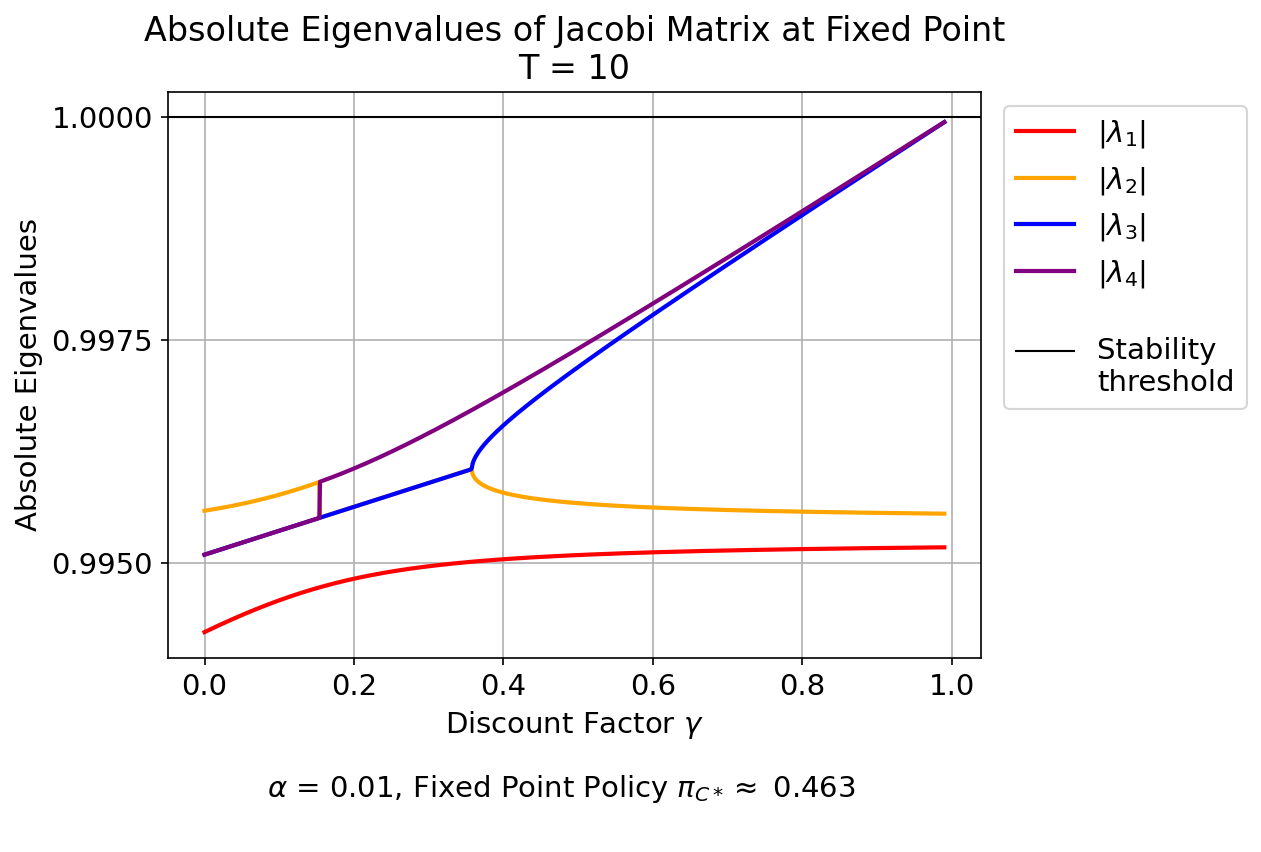

In [4]:
# enable inline plotting
%matplotlib inline

# define temperature and learning rate
temperature = 10
learning_rate = 0.01

fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
print(f"Fixed Point Policy at T = {temperature}", fixed_point_policy)

# calculate the eigenvalues and eigenvectors for a range of discount factors
discount_factor_array = np.linspace(0., 0.99, 1000)
# store eigenvalues, their absolute values and eigenvectors for each discount factor
eigenvalues_array = []
eigenvalues_betrag_array = []
eigenvectors_array = []
# calculate the eigenvalues and eigenvectors for each discount factor
for discount_factor in discount_factor_array:
    eigenvalues, eigenvectors = calculate_eigenvalues_and_eigenvectors(discount_factor, temperature, learning_rate, print_solution = False)
    eigenvalues_betrag = np.abs(eigenvalues)

    # Store the results
    eigenvalues_array.append(eigenvalues)
    eigenvalues_betrag_array.append(eigenvalues_betrag)
    eigenvectors_array.append(eigenvectors)

    # check if all eigenvectors are real valued
    if False:
        if np.all(np.isreal(eigenvectors)):
            print("Eigenvectors are real valued for discount factor =", discount_factor)

# show the bifurcation by plotting the absolute values of the eigenvalues
fontsize = 14
fig = plt.figure(figsize=(7, 5), dpi=150)
if True:
    linestyle_array = ['-', '-', '-', '-']
    color_array = ['red', 'orange', 'blue', 'purple']  
    for i in range(len(eigenvalues_betrag_array[0])):
        plt.plot(discount_factor_array, [eigenvalues_betrag[i] for eigenvalues_betrag in eigenvalues_betrag_array], label = f"|$\lambda_{i+1}$|", linestyle = linestyle_array[i], color = color_array[i], linewidth = 2)
    plt.xlabel(f"Discount Factor $\gamma$", fontsize = fontsize)
    plt.ylabel("Absolute Eigenvalues", fontsize = fontsize)
    plt.grid()
    # plot horizontal line at y = 1
    plt.axhline(y = 1, color = 'black', linestyle = '-', label = "\nStability \nthreshold", linewidth = 1)
    # plot vertical line at x = 0.745676 and x = 0.954936228028
    #plt.axvline(x = 0.745676, color = 'black', linestyle = '--', label = f"$\\gamma_c \\approx$ 0.75")
    #plt.axvline(x = 0.954936228028, color = 'black', linestyle = '-.', label = f"$\\gamma_c \\approx$ 0.95")
    # plot legend in box outside of plot
    plt.legend(loc = 'best', fontsize = fontsize, bbox_to_anchor=(1.01, 1))
    # set ticks of label to fontsize
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    # plot only 3 y ticks, otherwise it is too crowded
    plt.locator_params(axis='y', nbins=3)
    plt.title(f"Absolute Eigenvalues of Jacobi Matrix at Fixed Point\nT = {temperature}", fontsize = fontsize + 2)
    caption = (f'$\\alpha$ = {learning_rate}, Fixed Point Policy '+'$\pi_{C*}' +  f'\\approx$ {fixed_point_policy:.3f}\n'
            )
    plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize = fontsize)
    plt.savefig('Figures/DeterministicDynamics/bifurcation_PD.png', bbox_inches='tight', dpi=300)
    plt.show()

### plot eigenvalues in complex plane with discount factor as third axis. 

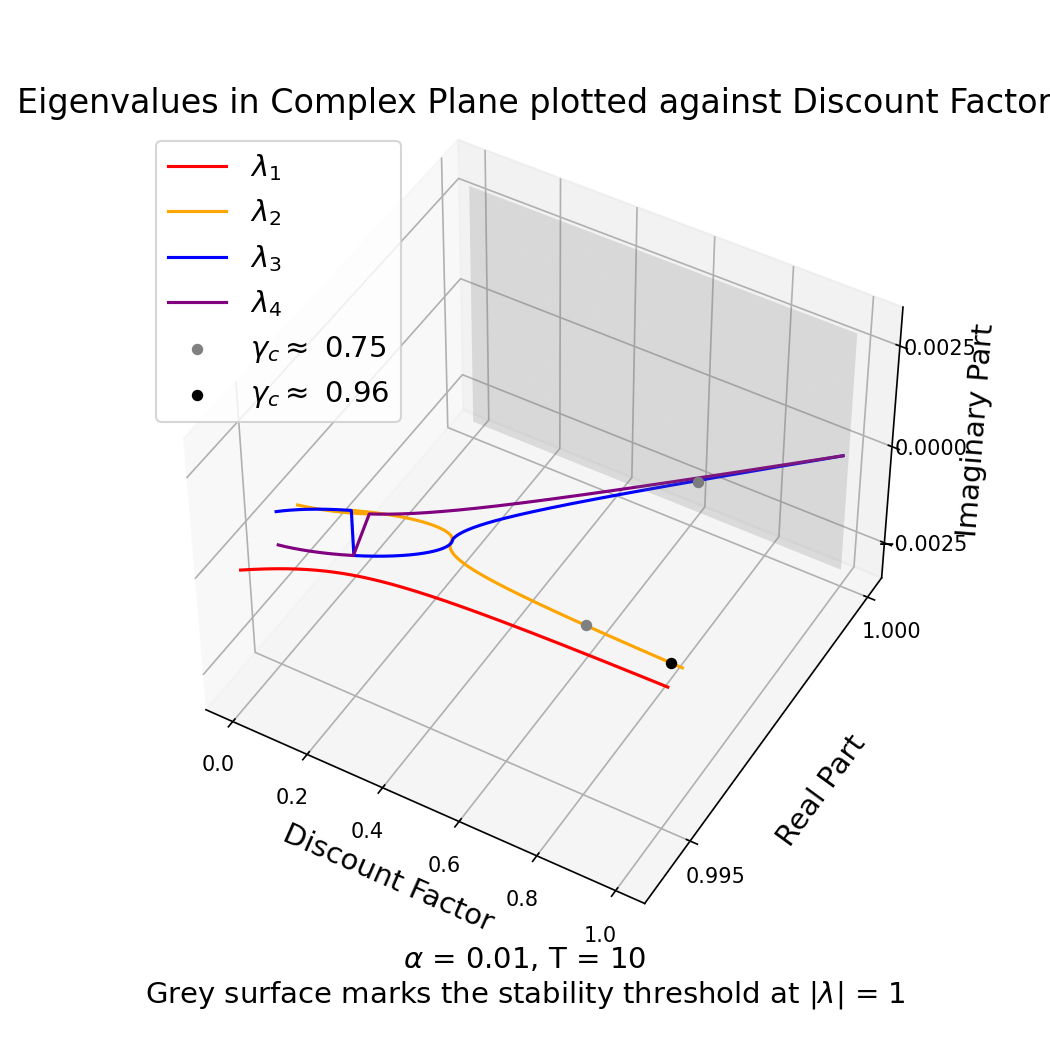

In [5]:
# enable inline plotting
%matplotlib widget

# show the bifurcation by plotting the second and third eigenvalues against the discount factor in 3D
fig = plt.figure(figsize=(7, 7), dpi=150)
ax = fig.add_subplot(111, projection='3d')
for i in range(len(eigenvalues_array[0])):
    ax.plot(discount_factor_array, [eigenvalues[i].real for eigenvalues in eigenvalues_array], [eigenvalues[i].imag for eigenvalues in eigenvalues_array], label = f"$\lambda_{i+1}$", linestyle = linestyle_array[i], color = color_array[i])

if False:
    # x-axis: discount factor, y-axis: real part, z-axis: imaginary part
    # plot the hyperplane at which the absolute value of the eigenvalues is 1. In the y and z axis, the hyperplane is a circle. In the 3D plot, it should be a cylinder oriented along the x-axis. 
    # The cylinder should have a radius of 1 and should be centered at the origin.
    # The cylinder is defined by the equation y^2 + z^2 = 1
    # plot a cylinder with radius 1, centered at the origin (y = 0, z = 0) and oriented along the x-axis
    # but only plot the cylinder in the region 
    u = np.linspace(0, 1, 1000)
    v = np.linspace(0, 2*np.pi, 1000)
    U, V = np.meshgrid(u, v)
    X = U
    Y = np.cos(V)
    Z = np.sin(V)
    ax.plot_surface(X, Y, Z, alpha = 0.2, color = 'grey')
    ax.legend()

# plots
if True:
    # plot a rectangular surface at real part = 1 (y = 1), parallel to the xz-plane
    y = 1
    X = np.linspace(0, 1, 100)
    Z = np.linspace(-0.003, 0.003, 100)
    X, Z = np.meshgrid(X, Z)
    Y = y * np.ones(X.shape)
    ax.plot_surface(X, Y, Z, alpha = 0.2, color = 'grey')

    # plot the two points, where eigenvalues cross the stability threshold
    x_bifurcation_1 = 0.745676
    y_bifurcation_eigenvalue_2 = eigenvalues_array[int(x_bifurcation_1 * 1000)][1].real
    z_bifurcation_eigenvalue_2 = eigenvalues_array[int(x_bifurcation_1 * 1000)][1].imag
    y_bifurcation_eigenvalue_3 = eigenvalues_array[int(x_bifurcation_1 * 1000)][2].real
    z_bifurcation_eigenvalue_3 = eigenvalues_array[int(x_bifurcation_1 * 1000)][2].imag
    ax.scatter(x_bifurcation_1, y_bifurcation_eigenvalue_2, z_bifurcation_eigenvalue_2, color = 'grey', label = f"$\\gamma_c \\approx$ 0.75")
    ax.scatter(x_bifurcation_1, y_bifurcation_eigenvalue_3, z_bifurcation_eigenvalue_3, color = 'grey')
    # plot the point, where eigenvalues become real
    x_bifurcation_2 = 0.962#54936228028
    y_bifurcation_eigenvalue_2 = eigenvalues_array[int(x_bifurcation_2 * 1000)][1].real
    z_bifurcation_eigenvalue_2 = eigenvalues_array[int(x_bifurcation_2 * 1000)][1].imag
    ax.scatter(x_bifurcation_2, y_bifurcation_eigenvalue_2, z_bifurcation_eigenvalue_2, color = 'black', label = f"$\\gamma_c \\approx$ 0.96")
    plt.legend(loc="upper left", fontsize = fontsize)

    # det azimutal and elevation angle
    ax.view_init(45, -60) # (elevation, azimuth)
    # set fontsize of ticks
    #ax.tick_params(axis='both', which='major', labelsize=fontsize)
    # only plot two ticks on the real axis
    ax.locator_params(axis='y', nbins=2)
    ax.locator_params(axis='z', nbins=3)
    ax.set_xlabel("Discount Factor", fontsize = fontsize)
    ax.set_ylabel("Real Part", fontsize = fontsize)
    ax.set_zlabel("Imaginary Part", fontsize = fontsize)

    ax.set_title(f"Eigenvalues in Complex Plane plotted against Discount Factor.", fontsize = fontsize + 2)
    caption = (f'$\\alpha$ = {learning_rate}, T = {temperature}\n'
                f'Grey surface marks the stability threshold at |$\lambda$| = 1'
            )
    plt.figtext(0.5, 0.05, caption, wrap=True, horizontalalignment='center', fontsize = fontsize)
    plt.show()


### Plot a 3D plot: x-axis: discount factor, y-axis: absolute eigenvalues, z-axis: Temperature

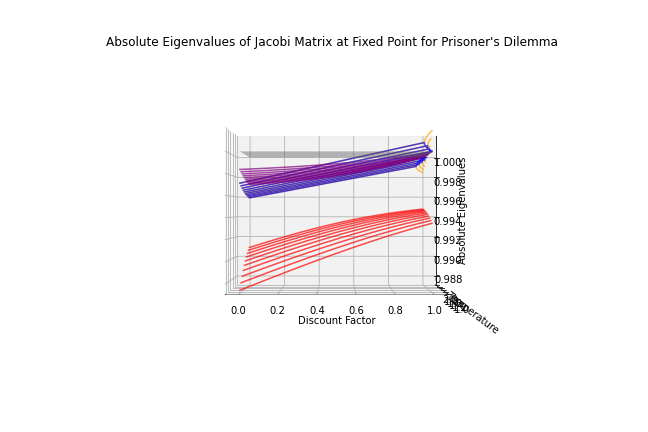

In [6]:
# enable widget for interactive plotting
%matplotlib widget

# define learning rate
learning_rate = 0.01

#define temperature array
temperature_min, temperature_max = 1, 2
temperature_array = np.linspace(temperature_min, temperature_max, 10)
eigenvalues_betrag_array_array = []

for temperature in temperature_array:
    # calculate the fixed point policy 
    fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
    # calculate the eigenvalues and eigenvectors for a range of discount factors
    discount_factor_array = np.linspace(0., 0.994, 995)
    # store eigenvalues, their absolute values and eigenvectors for each discount factor
    eigenvalues_array = []
    eigenvalues_betrag_array = []
    eigenvectors_array = []
    # calculate the eigenvalues and eigenvectors for each discount factor
    for discount_factor in discount_factor_array:
        eigenvalues, eigenvectors = calculate_eigenvalues_and_eigenvectors(discount_factor, temperature, learning_rate, print_solution = False)
        eigenvalues_betrag = np.abs(eigenvalues)

        # Store the results
        eigenvalues_array.append(eigenvalues)
        eigenvalues_betrag_array.append(eigenvalues_betrag)
        eigenvectors_array.append(eigenvectors)

        # check if all eigenvectors are real valued
        if False:
            if np.all(np.isreal(eigenvectors)):
                print("Eigenvectors are real valued for discount factor =", discount_factor)
    # store the results for each temperature
    eigenvalues_betrag_array_array.append(eigenvalues_betrag_array)

# plot a 3D plot. x-axis: discount factor, y-axis: Temperature, z-axis: absolute eigenvalues,
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
# iterate over all temperatures
for i in range(len(temperature_array)):
    eigenvalues_betrag_array = eigenvalues_betrag_array_array[i]
    # iterate over all eigenvalues
    for j in range(len(eigenvalues_betrag_array[0])): 
        ax.plot(discount_factor_array, [temperature_array[i]] * len(discount_factor_array), [eigenvalues_betrag[j] for eigenvalues_betrag in eigenvalues_betrag_array], 
                label = f"$T = {temperature_array[i]}$",
                color = color_array[j],
                alpha = 0.7)

# plot the stability threshold plane at z = 1
X = np.linspace(0, 1, 100)
Y = np.linspace(temperature_min, temperature_max, 100)
X, Y = np.meshgrid(X, Y)
Z = 1 * np.ones(X.shape)
ax.plot_surface(X, Y, Z, alpha = 0.5, color = 'grey')

ax.set_xlabel("Discount Factor")
ax.set_zlabel("Absolute Eigenvalues")
ax.set_ylabel("Temperature")
ax.set_title(f"Absolute Eigenvalues of Jacobi Matrix at Fixed Point for Prisoner's Dilemma")
# det azimutal and elevation angle
ax.view_init(0, -90) # (elevation, azimuth)
plt.show()

### Plot Eigenvectors in $\Delta$-Q space

Eigenvalue 1: 0.9933632897825567
Eigenvector: [ 0.12594666 -0.69579986  0.12594666 -0.69579986]
Eigenvector projection: [-0.8217465169493794, -0.8217465169493904]

Eigenvalue 2: 1.001426901323291
Eigenvector: [ 0.40319938  0.58088747 -0.40319938 -0.58088747]
Eigenvector projection: [0.1776880877309453, -0.17768808773095257]

Eigenvalue 3: 1.0003039996508327
Eigenvector: [ 0.47336844  0.52528308 -0.47336844 -0.52528308]
Eigenvector projection: [0.051914640714978366, -0.0519146407149802]

Eigenvalue 4: 0.9999068467335324
Eigenvector: [0.50627825 0.49364191 0.50627825 0.49364191]
Eigenvector projection: [-0.01263633780360418, -0.01263633780365414]



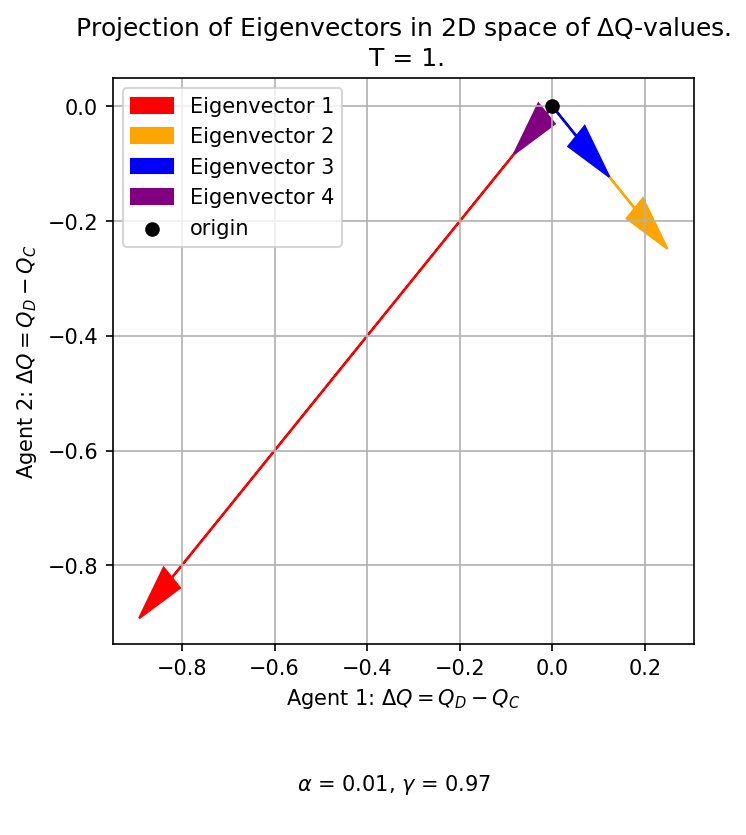

In [7]:
# enable inline plotting
%matplotlib inline

reward_function = reward_matrix_for_two_player_PD
reward_matrices, game_title, first_action_title = get_individual_matrices(reward_function)

# Define the parameters
learning_rate = 0.01
discount_factor = 0.97 # Bifurcation at 0.745675... and 0.954936228028...
temperature = 1

# calculate the fixed point policy, the target Q-values and eigenvalues and eigenvectors
fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
Q_target_C, Q_target_D = calculate_target_Q_values(fixed_point_policy, discount_factor, print_solution=False)
eigenvalues, eigenvectors = calculate_eigenvalues_and_eigenvectors(discount_factor, temperature, learning_rate, print_solution = False)

# plot the projection of the eigenvectors in the 2D space of delta Q-values as arrows
squaresize = 5
fig = plt.figure(figsize=(squaresize, squaresize), dpi=150)
color_array = ['red', 'orange', 'blue', 'purple']  
if True:
    # plot projection of eigenvectors in delta Q-space
    eigenvectors_projection = []
    for i, eigenvector in enumerate(eigenvectors.T):
        print(f"Eigenvalue {i+1}:", eigenvalues[i])
        print("Eigenvector:", eigenvector)

        if discount_factor < 0.95 and (i == 1 or i == 2):
            # continue if the eigenvector is complex
            print()
            continue

        eigenvector_projection = [eigenvector[1] - eigenvector[0], eigenvector[3] - eigenvector[2]]
        eigenvectors_projection.append(eigenvector_projection)
        print("Eigenvector projection:", eigenvector_projection)
        print()
        plt.arrow(0, 0, eigenvector_projection[0].real, eigenvector_projection[1].real, head_width=0.05, head_length=0.1, fc=color_array[i], ec=color_array[i], label=f'Eigenvector {i+1}')

    plt.scatter(0, 0, marker='o', color='black', label='origin', zorder=10)
    plt.title(f'Projection of Eigenvectors in 2D space of $\Delta$Q-values.\n T = {temperature}.')
    caption = (f'$\\alpha$ = {learning_rate}, $\\gamma$ = {discount_factor}\n'
            )
    plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center')
    plt.xlabel('Agent 1: $\Delta Q = Q_D - Q_C$')
    plt.ylabel('Agent 2: $\Delta Q = Q_D - Q_C$')
    plt.grid()
    plt.legend()
    plt.show()


### Test for Bifurcation at $\gamma \approx 0.745675$

Initial probabilities: [0.5, 0.47502081252106]


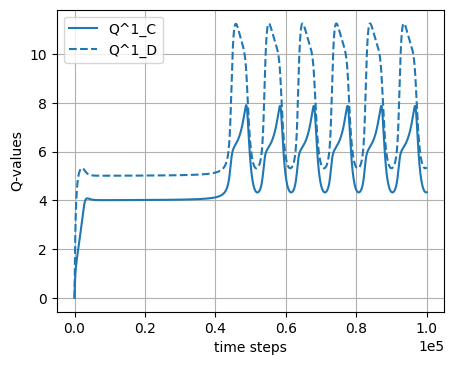

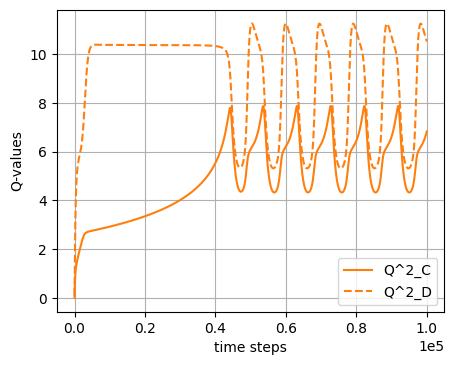

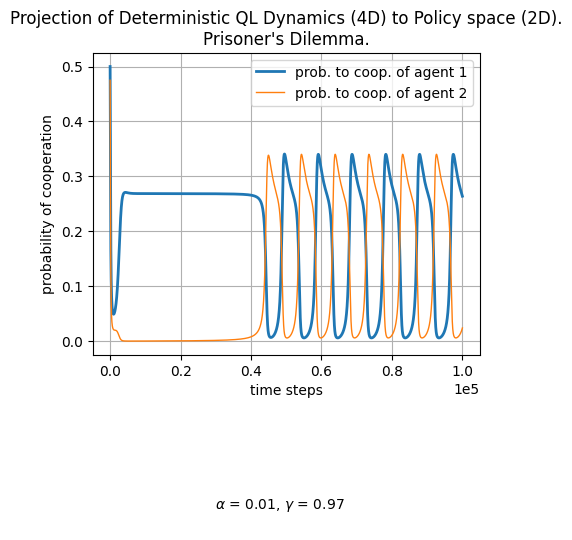

---------------- Final values ----------------
agent 1 Q-values: [4.33263662 5.35785295]
agent 1 prob. to coop.: 0.2640125675131434
agent 2 Q-values: [ 6.82650212 10.51789628]
agent 2 prob. to coop.: 0.024330476956455908


In [8]:
# Enable inline plotting
%matplotlib inline
dpi = 100
figsize = (5,4)

reward_function = reward_matrix_for_two_player_PD
reward_matrices, game_title, first_action_title = get_individual_matrices(reward_function)

# Define the parameters
learning_rate = 0.01
discount_factor = 0.8 # Bifurcation at 0.745675... and 0.954936228028...
temperature = 1

# calculate the fixed point policy and the target Q-values
fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
Q_target_C, Q_target_D = calculate_target_Q_values(fixed_point_policy, discount_factor)

# Define base value around which the Q-values are centered if given initial probabilities
base_value = 0# Q_target_C + (Q_target_D - Q_target_C)/2 
num_time_steps = int(1e5)

# define the initial Q-values
Case = 3
if Case == 1: 
    # generate the initial Q-values for the agents from the initial probabilities centered around the base value
    initial_probability_pair = (0.9, 0.7)
    Q_values_initial_list = [generate_q_values(probability, temperature, base_value) for probability in initial_probability_pair]
    print("Initial Q-values:", Q_values_initial_list)
elif Case == 2:
    # round the target Q-values to the third decimal to generate asymmetric initial Q-values very close to the fixed point
    Q_target_C_rounded = np.round(Q_target_C, 3)
    Q_target_D_rounded = np.round(Q_target_D, 3)

    # define the initial Q-values manually
    Q_values_initial_list = [np.array([Q_target_C, Q_target_D], dtype=float), np.array([Q_target_C_rounded, Q_target_D_rounded], dtype=float)] 

    # print the resulting initial probabilities
    initial_probability_pair = [np.exp(Q_values_initial[0] / temperature) / np.sum(np.exp(Q_values_initial / temperature)) for Q_values_initial in Q_values_initial_list]
    print("Initial probabilities:", initial_probability_pair)
elif Case == 3:
    Q_values_initial_list = [np.array([0, 0], dtype=float), np.array([0, 0.1], dtype=float)]
    # print the resulting initial probabilities
    initial_probability_pair = [np.exp(Q_values_initial[0] / temperature) / np.sum(np.exp(Q_values_initial / temperature)) for Q_values_initial in Q_values_initial_list]
    print("Initial probabilities:", initial_probability_pair)

# define the agents
agents = [DeterministicAgent(Q_values_initial, learning_rate, discount_factor, temperature) for Q_values_initial in Q_values_initial_list]

# run deterministic Q-learning model
for time_step in range(num_time_steps):
    Q_step(agents, reward_matrices)

# plot dynamics in Q-space
linestyle_array = ['-', '--']
linewidth_array = [2, 1]
color_array = ['C0', 'C1']
if False:
    squaresize = 6
    fig = plt.figure(figsize=(squaresize, squaresize))
    for i, agent in enumerate(agents):
        plt.plot(np.array(agent.Q_values_history)[:, 0], np.array(agent.Q_values_history)[:, 1], label=f'agent {i+1}', linestyle=linestyle_array[i])
        plt.scatter(agent.Q_values_history[0][0], agent.Q_values_history[0][1], marker='+', color='black', zorder=10, label=f'agent {i+1}: {agent.Q_values_initial}')
        plt.scatter(agent.Q_values_history[-1][0], agent.Q_values_history[-1][1], marker='x', color="red", zorder=10)
    plt.title(f'Deterministic QL Dynamics (4D).\n{game_title}.')
    if Case == 1:
        caption = (f'$\\alpha$ = {learning_rate}, T = {temperature}, $\\gamma$ = {discount_factor}\n'
                    f'Q-values are initialised around {base_value}.\nTrajectories span {num_time_steps:.0e} time steps.\n'
                )
    elif Case == 2:
        caption = (f'$\\alpha$ = {learning_rate}, T = {temperature}, $\\gamma$ = {discount_factor}\n'
                    f'Initial Q-values: {Q_values_initial_list}.\nInitial probabilities: {np.round(initial_probability_pair, 4)}\nTrajectories span {num_time_steps:.0e} time steps.\n'
                )
    elif Case == 3:
        caption = (f'$\\alpha$ = {learning_rate}, T = {temperature}, $\\gamma$ = {discount_factor}\n'
                    f'Initial Q-values: {Q_values_initial_list}.\nInitial probabilities: {np.round(initial_probability_pair, 4)}\nTrajectories span {num_time_steps:.0e} time steps.\n'
                )
    plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center')
    plt.xlabel('Q-value Cooperate')
    plt.ylabel('Q-value Defect')
    plt.legend()
    plt.grid()
    # Ensure the axes are symmetrically scaled
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()

# plot Q-values over time for each agent seperate
if True:
    for i, agent in enumerate(agents):
        color = color_array[i]
        fig = plt.figure(figsize=figsize, dpi=dpi)
        plt.plot(np.arange(num_time_steps), np.array(agent.Q_values_history)[:, 0], label=f'Q^{i+1}_C', linestyle=linestyle_array[0], color=color)
        plt.plot(np.arange(num_time_steps), np.array(agent.Q_values_history)[:, 1], label=f'Q^{i+1}_D', linestyle=linestyle_array[1], color=color)
        #plt.scatter(num_time_steps, agent.prob_vector_history[-1][0], marker="x", label=f'final prob. to coop. of {i+1}: {agent.prob_vector_history[-1][0]:.3f}')
        plt.xlabel('time steps')
        # use scientific notation for the x-axis
        plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
        plt.ylabel('Q-values')
        plt.legend()
        plt.grid()
# plot dynamics in policy-space
if True:
    fig = plt.figure(figsize=figsize, dpi=dpi)
    for i, agent in enumerate(agents):
        plt.plot(np.arange(num_time_steps), np.array(agent.prob_vector_history)[:, 0], label=f'prob. to coop. of agent {i+1}', linewidth=linewidth_array[i])
        #plt.scatter(num_time_steps, agent.prob_vector_history[-1][0], marker="x", label=f'final prob. to coop. of {i+1}: {agent.prob_vector_history[-1][0]:.3f}')
    plt.title(f'Projection of Deterministic QL Dynamics (4D) to Policy space (2D).\n{game_title}.')
    if Case == 1:
        caption = (f'$\\alpha$ = {learning_rate}, T = {temperature}, $\\gamma$ = {discount_factor}\n'
                    f'Q-values are initialised around {base_value}.\nTrajectories span {num_time_steps:.0e} time steps.\n'
                )
    elif Case == 2:
        caption = (f'$\\alpha$ = {learning_rate}, T = {temperature}, $\\gamma$ = {discount_factor}\n'
                    f'Initial Q-values: {Q_values_initial_list}.\nInitial probabilities: {np.round(initial_probability_pair, 4)}\nTrajectories span {num_time_steps:.0e} time steps.\n'
                )
    plt.figtext(0.5, -0.3, caption, wrap=True, horizontalalignment='center')
    plt.xlabel('time steps')
    # use scientific notation for the x-axis
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    plt.ylabel('probability of cooperation')
    plt.legend()
    plt.grid()

if True:
    plt.savefig(f'Figures/PaperFigures/PD_DeterministicDynamics_p1_{initial_probability_pair[0]}_p2_{initial_probability_pair[1]}.pdf', bbox_inches='tight', dpi=dpi)
plt.show()

# print final values
print("---------------- Final values ----------------")
for i, agent in enumerate(agents):
    print("agent", i+1, "Q-values:", agent.Q_values)
    print("agent", i+1, "prob. to coop.:", agent.get_prob_vector()[0])

## Flowplots in policy space

Run finished for initial probability pair (0.1, 0.9) Progress: 1/11
Run finished for initial probability pair (0.5, 0.9) Progress: 2/11
Run finished for initial probability pair (0.7, 0.9) Progress: 3/11
Run finished for initial probability pair (0.9, 0.9) Progress: 4/11
Run finished for initial probability pair (0.9, 0.7) Progress: 5/11
Run finished for initial probability pair (0.1, 0.5) Progress: 6/11
Run finished for initial probability pair (0.5, 0.5) Progress: 7/11
Run finished for initial probability pair (0.9, 0.5) Progress: 8/11
Run finished for initial probability pair (0.1, 0.1) Progress: 9/11
Run finished for initial probability pair (0.5, 0.1) Progress: 10/11
Run finished for initial probability pair (0.9, 0.1) Progress: 11/11


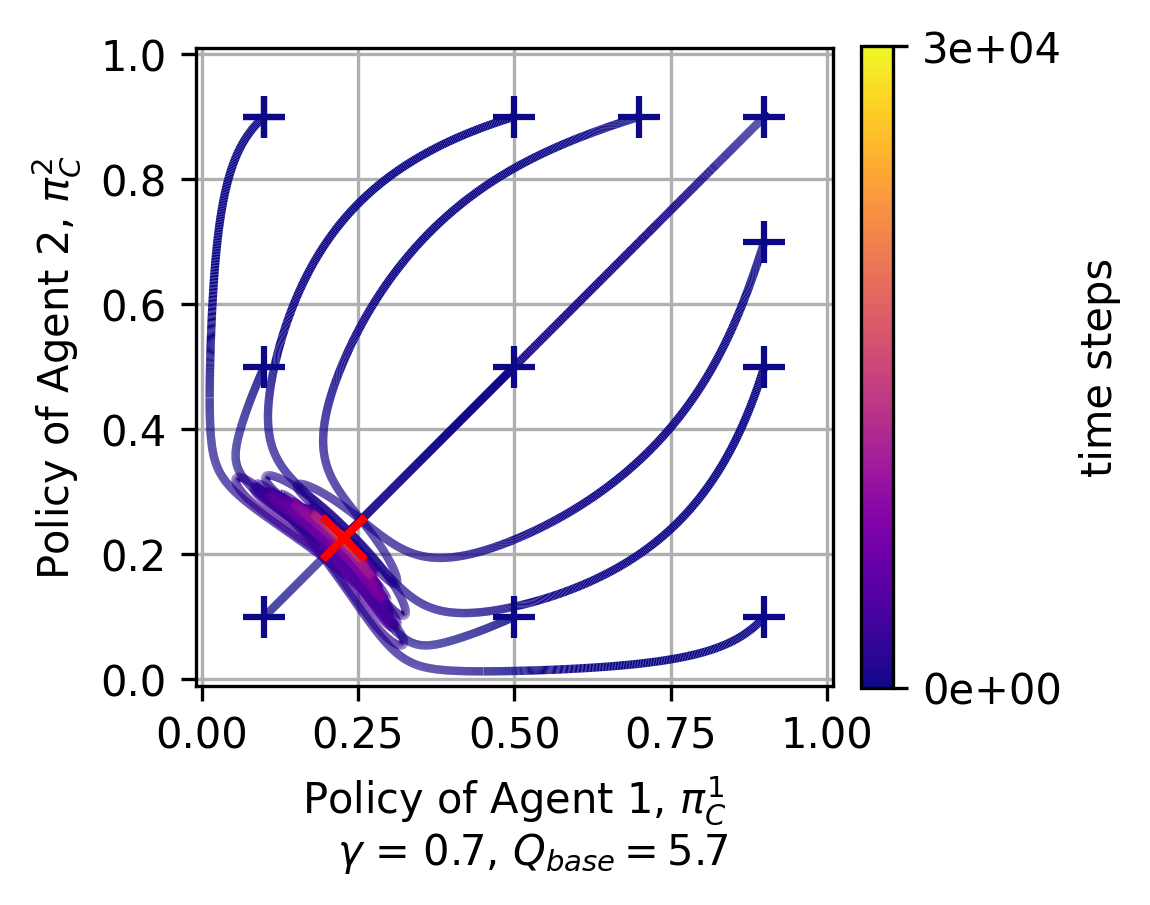

In [9]:
# enable inline plotting
%matplotlib inline
figsize = (3, 3)
dpi = 300

reward_function = reward_matrix_for_two_player_PD
reward_matrices, game_title, first_action_title = get_individual_matrices(reward_function)

# Define the parameters
learning_rate = 0.01
discount_factor = 0.7
temperature = 1

# calculate the fixed point policy, the target Q-values and eigenvalues and eigenvectors
fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
Q_target_C, Q_target_D = calculate_target_Q_values(fixed_point_policy, discount_factor)
eigenvalues, eigenvectors = calculate_eigenvalues_and_eigenvectors(discount_factor, temperature, learning_rate, print_solution = False)

# Define base value around which the Q-values are centered if given initial probabilities
base_value = Q_target_C + (Q_target_D - Q_target_C)/2  #0 * 1/(1-discount_factor)
num_time_steps = int(3e4)

# generate initial probability pairs for the complete 1x1 square in policy space
if False: # use this for symmetric initial probability pairs
    #x = np.array([0.9])
    #initial_probability_pairs = [(x[i], x[j]) for i in range(len(x)) for j in range(len(x))]
    initial_probability_pairs = [(0.5, 0.51)]
else: # use this for specific initial probability pairs
    initial_probability_pairs = [(0.1, 0.9), (0.5, 0.9), (0.7,0.9), (0.9, 0.9), (0.9,0.7),
                        (0.1, 0.5), (0.5, 0.5), (0.9, 0.5),
                        (0.1, 0.1), (0.5, 0.1), (0.9, 0.1)]

# Plot the dynamics in policy space
fig = plt.figure(figsize=figsize, dpi=dpi)
plot_time_evolution = True
label_flag_added = False # Flag to add labels only once
marker_size = 100
color_start_scatter = plt.cm.plasma(0.0) # dark purple
color_end_scatter = 'red' #plt.cm.plasma(1.0) # bright yellow
for i, initial_probability_pair in enumerate(initial_probability_pairs):
    # generate the initial Q-values for the agents from the initial probabilities centered around the base value
    Q_values_initial_list = [generate_q_values(probability, temperature, base_value) for probability in initial_probability_pair]

    # define the agents
    agents = [DeterministicAgent(Q_values_initial, learning_rate, discount_factor, temperature) for Q_values_initial in Q_values_initial_list]
    
    # run deterministic Q-learning model
    for time_step in range(num_time_steps):
        Q_step(agents, reward_matrices)
        # print out the progress
        #if time_step % int(num_time_steps/10) == 0:
            #print(f"Progress: {time_step/num_time_steps * 100:.0f}%")
    print("Run finished for initial probability pair", initial_probability_pair, f"Progress: {i+1}/{len(initial_probability_pairs)}")

    # plot only every n-th time step to reduce the number of lines
    n = 1
    
    # get the histories of probabilities to cooperate for each agent 
    prob_coop_of_agent_1_list = [vector[0] for vector in agents[0].prob_vector_history[::n]]
    prob_coop_of_agent_2_list = [vector[0] for vector in agents[1].prob_vector_history[::n]]

    # combine for each time steps the probabilities of both agents so that we can plot in the 1x1 square of policy space
    prob_coop_list = np.array([prob_coop_of_agent_1_list, prob_coop_of_agent_2_list]).T

    if plot_time_evolution:
        #print("len prob_coop_list", len(prob_coop_list))
        # Create a list of lines to plot the time evolution of the trajectories with a color gradient
        lines = [ [prob_coop_list[i], prob_coop_list[i+1]] for i in range(len(prob_coop_list)-1)]
        # Create a LineCollection
        lc = LineCollection(lines, cmap='plasma', linewidths=2, alpha=1)
        # Set the colors of the lines
        lc.set_array(np.linspace(0, 1, len(prob_coop_list)))
        # Add the LineCollection to the plot
        plt.gca().add_collection(lc)

        # Add a colorbar for the time evolution ONLY ONCE
        if i == 0:
            cbar = plt.colorbar(lc, fraction=0.046, pad=0.04)
            cbar.set_label('time steps')
            # lc is normalized so we need to set the ticks manually
            tick_values = [0, 1]
            tick_labels = [0, num_time_steps]
            cbar.set_ticks(tick_values)  # Set the ticks to the desired positions
            # Format tick labels into scientific notation manually
            cbar.set_ticklabels(["{:.0e}".format(tick_label) for tick_label in tick_labels])
    else:
        # plot dynamics in policy-space in the 1x1 square
        plt.plot(prob_coop_list[:, 0], prob_coop_list[:, 1], alpha = 1)
    plt.scatter(prob_coop_list[0, 0], prob_coop_list[0, 1], marker='+', color=color_start_scatter, zorder=10, s=marker_size)
    plt.scatter(prob_coop_list[-1, 0], prob_coop_list[-1, 1], marker='x', color=color_end_scatter, zorder=10, s=marker_size)
    # add labels only once
    if not label_flag_added:
        plt.scatter(prob_coop_list[0, 0], prob_coop_list[0, 1], marker='+', color=color_start_scatter, label='Start', s=marker_size)
        plt.scatter(prob_coop_list[-1, 0], prob_coop_list[-1, 1], marker='x', color=color_end_scatter, label='End', s=marker_size)
        label_flag_added = True

# add cosmetics to the plot
fontsize = None#12
Figure_format_for_publication = True
if True:
    #plt.title(f'Projection of New Deterministic QL Dynamics (4D)\n to Policy space (2D).', fontsize=fontsize+2)
    if plot_time_evolution:
        if Figure_format_for_publication:
            caption = (f'$\\gamma$ = {discount_factor}, ' +r'$Q_{base} =$' + f'{base_value:.1f}')
            plt.figtext(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=fontsize)
        else:
            caption = (f'$\\alpha$ = {learning_rate}, T = {temperature}, $\\gamma$ = {discount_factor}\n'
                    f'Q-values are initialised around {base_value:.2f}.')
            plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=fontsize)
    else:
        caption = (f'$\\alpha$ = {learning_rate}, T = {temperature}, $\\gamma$ = {discount_factor}\n'
                    f'Q-values are initialised around {base_value:.2f}.'
                    f'\nTrajectories span {num_time_steps:.0e} time steps.\n'
                )
        plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=fontsize)
    # plt.xlabel(f'Agent 1: Prob. of {first_action_title[0]}, $\pi^1_{first_action_title[0]}$', fontsize=fontsize)
    # plt.ylabel(f'Agent 2: Prob. of {first_action_title[0]}, $\pi^2_{first_action_title[0]}$', fontsize=fontsize)
    plt.xlabel(f'Policy of Agent 1, $\pi^1_{first_action_title[0]}$', fontsize=fontsize)
    plt.ylabel(f'Policy of Agent 2, $\pi^2_{first_action_title[0]}$', fontsize=fontsize)
    # set ticks of label to fontsize
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    # fix x and y axis to unit square
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.grid()
    #plt.legend(loc='best', fontsize=fontsize)
    # Ensure the axes are symmetrically scaled
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

# save figure
if True:
    plt.savefig(f'Figures/PaperFigures/PD_DeterministicDynamics_discount_{discount_factor}_Qbase_{base_value}_temp_{temperature}_learningRate_{learning_rate}_numTimeSteps_{num_time_steps}.jpg', dpi=300, bbox_inches='tight')
plt.show()

## Flowplot in $\Delta$-Q space

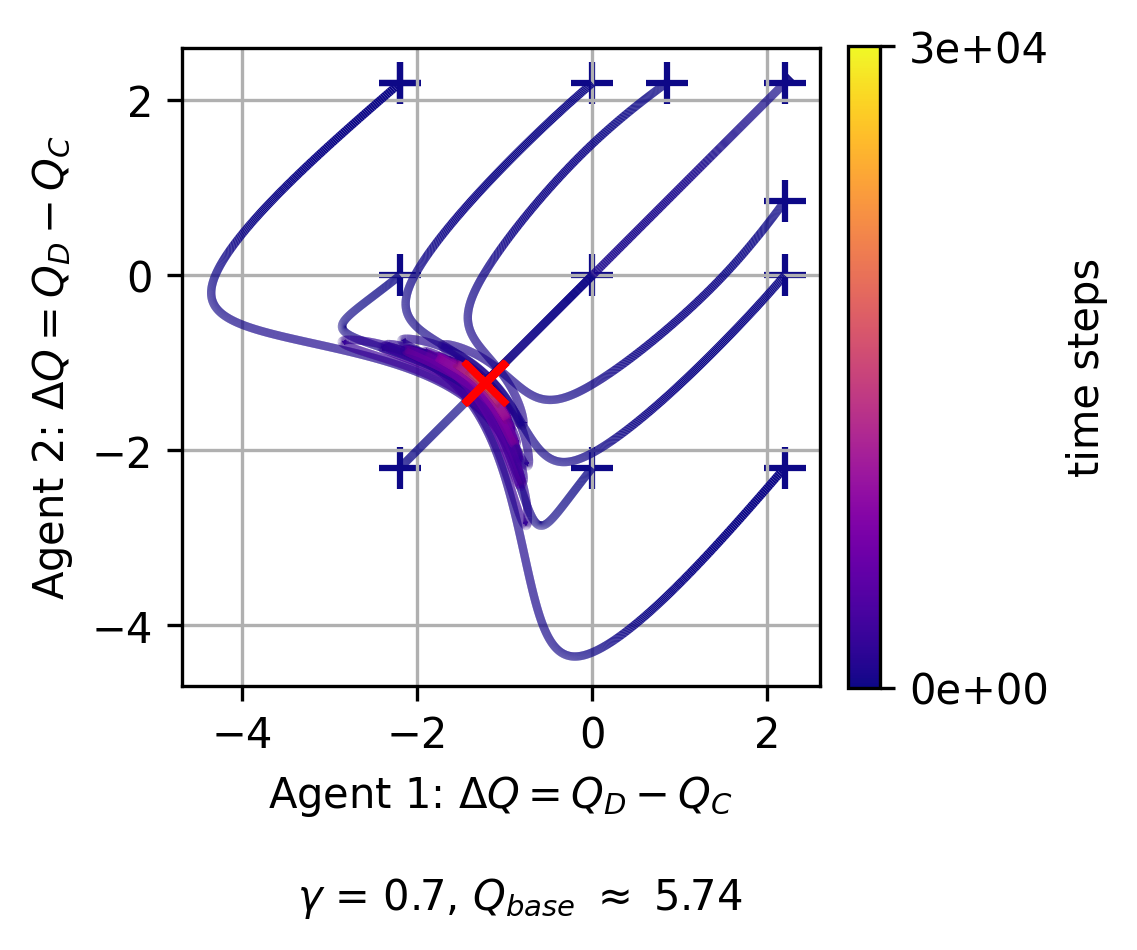

In [10]:
# Enable inline plotting
%matplotlib inline

# choose the reward function
reward_function = reward_matrix_for_two_player_PD
reward_matrices, game_title, first_action_title = get_individual_matrices(reward_function)

# Define the parameters
learning_rate = learning_rate
discount_factor = discount_factor
temperature = temperature

# calculate the fixed point policy, the target Q-values and eigenvalues and eigenvectors
fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
Q_target_C, Q_target_D = calculate_target_Q_values(fixed_point_policy, discount_factor)
eigenvalues, eigenvectors = calculate_eigenvalues_and_eigenvectors(discount_factor, temperature, learning_rate, print_solution = False)

# Define base value around which the Q-values are centered if given initial probabilities
base_value = base_value#0 #Q_target_C + (Q_target_D - Q_target_C)/2 

# generate initial probability pairs for the complete 1x1 square in policy space
if False: # use this for symmetric initial probability pairs
    x = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
    initial_probability_pairs = [(x[i], x[j]) for i in range(len(x)) for j in range(len(x))]
else: # use this for specific initial probability pairs
    #initial_probability_pairs = [(0.1, 0.9), (fixed_point_policy, 0.226), (fixed_point_policy, fixed_point_policy)]
    initial_probability_pairs = [(0.1, 0.9), (0.5, 0.9), (0.7,0.9), (0.9, 0.9), (0.9,0.7),
                        (0.1, 0.5), (0.5, 0.5), (0.9, 0.5),
                        (0.1, 0.1), (0.5, 0.1), (0.9, 0.1)]
    
# store outcomes in lists
delta_Q_history_agent_0_list = []
delta_Q_history_agent_1_list = []
sum_Q_history_list = []
diff_deltaQ_agent0_deltaQ_agent1_list = []
diff_Q_agent0_agent1_list = []

# loop over all initial probability pairs
for i, initial_probability_pair in enumerate(initial_probability_pairs):
    # generate the initial Q-values for the agents from the initial probabilities centered around the base value
    Q_values_initial_list = [generate_q_values(probability, temperature, base_value) for probability in initial_probability_pair]
    # define the agents
    agents = [DeterministicAgent(Q_values_initial, learning_rate, discount_factor, temperature) for Q_values_initial in Q_values_initial_list]
    
    # run deterministic Q-learning model
    for time_step in range(num_time_steps):
        Q_step(agents, reward_matrices)

    # extract relevant information of 4D dynamics in order to plot in lower dimensions
    delta_Q_history_agent_0 = np.array([Q_values[0] - Q_values[1] for Q_values in agents[0].Q_values_history])
    delta_Q_history_agent_1 = np.array([Q_values[0] - Q_values[1] for Q_values in agents[1].Q_values_history])
    sum_Q_history = np.array([np.sum(Q_values) for Q_values in agents[0].Q_values_history]) + np.array([np.sum(Q_values) for Q_values in agents[1].Q_values_history])
    diff_deltaQ_agent0_deltaQ_agent1 = delta_Q_history_agent_0 - delta_Q_history_agent_1
    diff_Q_agent0_agent1 = np.array([np.sum(Q_values) for Q_values in agents[0].Q_values_history]) - np.array([np.sum(Q_values) for Q_values in agents[1].Q_values_history]) # difference between the sum of Q-values of both agents

    # store outcomes in lists
    delta_Q_history_agent_0_list.append(delta_Q_history_agent_0)
    delta_Q_history_agent_1_list.append(delta_Q_history_agent_1)
    sum_Q_history_list.append(sum_Q_history)
    diff_deltaQ_agent0_deltaQ_agent1_list.append(diff_deltaQ_agent0_deltaQ_agent1)
    diff_Q_agent0_agent1_list.append(diff_Q_agent0_agent1)

# plot the first two axis in 2D
plot_time_evolution = True
fig = plt.figure(figsize=figsize, dpi=dpi)
marker_size = 100
for i, initial_probability_pair in enumerate(initial_probability_pairs):
    # plot the first two axis in 2D
    if plot_time_evolution:
        # Create a list of lines to plot the time evolution of the trajectories with a color gradient
        lines = [ [(delta_Q_history_agent_0_list[i][j], delta_Q_history_agent_1_list[i][j]) , (delta_Q_history_agent_0_list[i][j+1], delta_Q_history_agent_1_list[i][j+1])] for j in range(len(delta_Q_history_agent_0_list[i])-1) ]
        # Create a LineCollection
        lc = LineCollection(lines, cmap='plasma', linewidths=2, alpha=1, zorder=2)
        # Set the colors of the lines
        lc.set_array(np.linspace(0, 1, num_time_steps))
        # Add the LineCollection to the plot
        plt.gca().add_collection(lc)

        # Add a colorbar for the time evolution ONLY ONCE
        if i == 0:
            cbar = plt.colorbar(lc, fraction=0.046, pad=0.04)
            cbar.set_label('time steps')
            # lc is normalized so we need to set the ticks manually
            tick_values = [0, 1]
            tick_labels = [0, num_time_steps]
            cbar.set_ticks(tick_values)  # Set the ticks to the desired positions
            # Format tick labels into scientific notation manually
            cbar.set_ticklabels(["{:.0e}".format(tick_label) for tick_label in tick_labels])
    else:
        plt.plot(delta_Q_history_agent_0_list[i], delta_Q_history_agent_1_list[i], label=f'{initial_probability_pair}')
    # plot the initial and final points
    plt.scatter(delta_Q_history_agent_0_list[i][0], delta_Q_history_agent_1_list[i][0], marker='+', color=color_start_scatter, zorder=1, s=marker_size)
    plt.scatter(delta_Q_history_agent_0_list[i][-1], delta_Q_history_agent_1_list[i][-1], marker='x', color=color_end_scatter, zorder=10, s=marker_size)
    # add labels only once
    if i == 0:
        plt.scatter(delta_Q_history_agent_0_list[i][0], delta_Q_history_agent_1_list[i][0], marker='+', color=color_start_scatter, label='initial', s=marker_size)
        plt.scatter(delta_Q_history_agent_0_list[i][-1], delta_Q_history_agent_1_list[i][-1], marker='x', color=color_end_scatter, label='final', s=marker_size)

#plt.title(f'Projection of Deterministic QL Dynamics (4D)\nto 2D space of $\Delta$Q-values.', fontsize=fontsize+2)
caption = (f'$\\gamma$ = {discount_factor}, ' + r'$Q_{base}$' + f' $\\approx$ {base_value:.2f}'
        )
plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=fontsize)
plt.xlabel(f'Agent 1: $\Delta Q = Q_D - Q_C$', fontsize=fontsize)
plt.ylabel(f'Agent 2: $\Delta Q = Q_D - Q_C$', fontsize=fontsize)
# set ticks of label to fontsize
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid()
# ensure the axes are symmetrically scaled
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
# print legend outside of the plot so that it does not overlap with the plot
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 3D plot of multiple trajectories

x_min: -4.354680368447228, x_max: 2.2659715299999537, y_min: -4.354680368447228, y_max: 2.2659715299999537, z_min: -6.062198209499223, z_max: 6.062198209499223


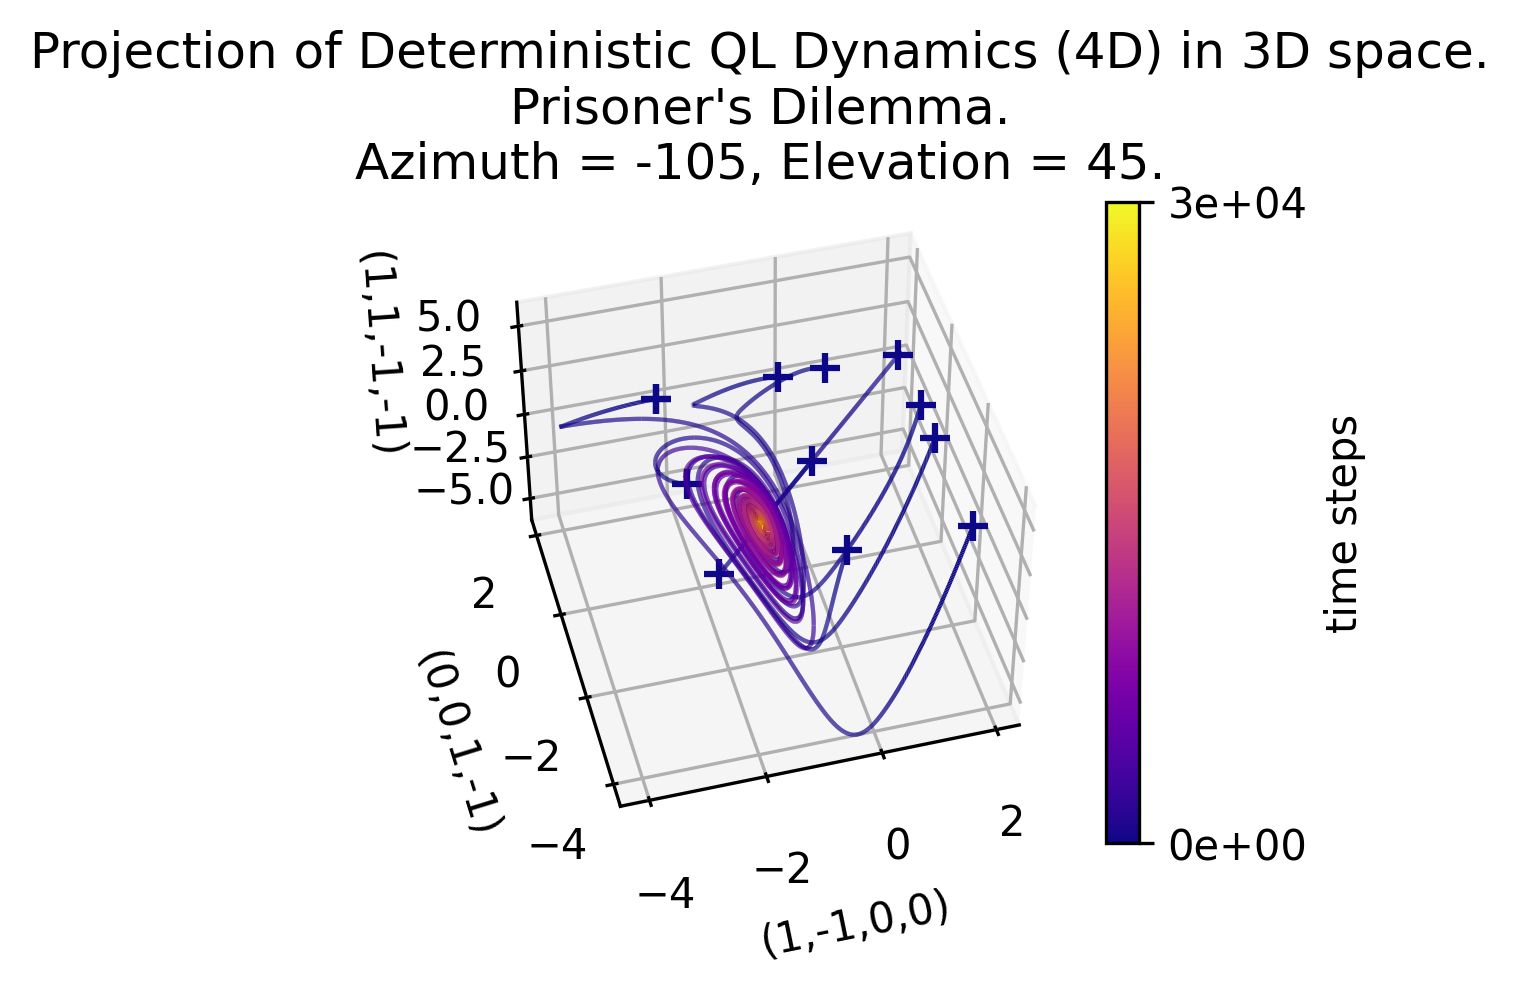

In [15]:
# Enable interactive plotting for 3D plot
%matplotlib inline

# plot the dynamics in a 3D plot.
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111, projection='3d')

# loop over all initial probability pairs
percentage_to_plot = 1
plot_time_evolution = True
skip_0909_trajectory = False
print_info = False
for i, initial_probability_pair in enumerate(initial_probability_pairs):
    if print_info:
        print(f"Initial prob {initial_probability_pair}, final values: " 
              f"Delta Q1 {delta_Q_history_agent_0_list[i][-1]:.3f}, " 
              f"Delta Q2 {delta_Q_history_agent_1_list[i][-1]:.3f}, "
              f"Sum Q {sum_Q_history_list[i][-1]:.3f}, "
              f"Diff Delta Q {diff_deltaQ_agent0_deltaQ_agent1_list[i][-1]:.3f}, "
              f"Diff Sum Q {diff_Q_agent0_agent1_list[i][-1]:.3f}"
                          )
    if skip_0909_trajectory and initial_probability_pair == (0.9, 0.9):
        print(f"Skipped trajectory with initial probability pair {initial_probability_pair}")
        continue

    # take only the last % of the data points to plot
    num_time_steps_to_plot = int(percentage_to_plot * num_time_steps)

    # get the data for the 3D plot from the lists
    delta_Q_history_agent_0 = delta_Q_history_agent_0_list[i][-num_time_steps_to_plot:]
    delta_Q_history_agent_1 = delta_Q_history_agent_1_list[i][-num_time_steps_to_plot:]
    sum_Q_agent0_agent1 = sum_Q_history_list[i][-num_time_steps_to_plot:]
    diff_Q_agent0_agent1 = diff_Q_agent0_agent1_list[i][-num_time_steps_to_plot:]
    diff_deltaQ_agent0_deltaQ_agent1 = diff_deltaQ_agent0_deltaQ_agent1_list[i][-num_time_steps_to_plot:]
    # Define a dictionary mapping variables to their names
    axis_label_names = {
        '(1,-1,0,0)': delta_Q_history_agent_0,
        '(0,0,1,-1)': delta_Q_history_agent_1,
        'Sum of Q values': sum_Q_agent0_agent1,
        'Diff Delta Q-values 1 and 2': diff_deltaQ_agent0_deltaQ_agent1,
        '(1,1,-1,-1)': diff_Q_agent0_agent1
    }

    # choose axes for the 3D plot
    x = delta_Q_history_agent_0
    y = delta_Q_history_agent_1
    z = diff_Q_agent0_agent1
    
    if plot_time_evolution:
        # Create a list of lines to plot the time evolution of the trajectories with a color gradient
        resolution = 1
        lines = [ [(x[j], y[j], z[j]) , (x[j+resolution], y[j+resolution], z[j+resolution])] for j in range(len(x)-resolution) ]
        # Create a Line3DCollection
        lc = Line3DCollection(lines, cmap='plasma', linewidths=1, alpha=1, zorder=2)
        # Set the colors of the lines
        lc.set_array(np.linspace(0, 1, num_time_steps_to_plot-1))
        # Add the LineCollection to the plot
        ax.add_collection3d(lc)

        # Add a colorbar for the time evolution ONLY ONCE
        if i == 0:
            cbar = plt.colorbar(lc, fraction=0.046, pad=0.04)
            cbar.set_label('time steps')
            # lc is normalized so we need to set the ticks manually
            tick_values = [0, 1]
            tick_labels = [(num_time_steps - num_time_steps_to_plot), num_time_steps]
            cbar.set_ticks(tick_values)
            # Format tick labels into scientific notation manually
            cbar.set_ticklabels(["{:.0e}".format(tick_label) for tick_label in tick_labels])
    else:
        ax.plot(x, y, z)
        
    # plot the initial and final points
    marker_size = 50
    ax.scatter(x[0], y[0], z[0], marker='+', color=color_start_scatter, s = marker_size, zorder=1)
    ax.scatter(x[-1], y[-1], z[-1], marker='x', color=color_end_scatter, s = marker_size, zorder=100)
    #add labels only once
    if i == 0:
        ax.scatter(x[0], y[0], z[0], marker='+', color=color_start_scatter, label='Start', s = marker_size)
        ax.scatter(x[-1], y[-1], z[-1], marker='x', color=color_end_scatter, label='End', s = marker_size)

# add cosmetics to the plot
if True:
    ax.set_xlabel([name for name, values in axis_label_names.items() if values is x][0])
    ax.set_ylabel([name for name, values in axis_label_names.items() if values is y][0])
    ax.set_zlabel([name for name, values in axis_label_names.items() if values is z][0])
    #ax.legend()
    # set axis to min and max values of all trajectories
    # if skip_0909_trajectory is True, the min and max values are calculated without the 0909 trajectory
    if skip_0909_trajectory:
        delta_Q_history_agent_0_list_filtered = [delta_Q_history_agent_0_list[i] for i in range(len(initial_probability_pairs)) if initial_probability_pairs[i] != (0.9, 0.9)]
        delta_Q_history_agent_1_list_filtered = [delta_Q_history_agent_1_list[i] for i in range(len(initial_probability_pairs)) if initial_probability_pairs[i] != (0.9, 0.9)]
        diff_Q_agent0_agent1_list_filtered = [diff_Q_agent0_agent1_list[i] for i in range(len(initial_probability_pairs)) if initial_probability_pairs[i] != (0.9, 0.9)]
        x_min, x_max = min([min(x[-num_time_steps_to_plot:]) for x in delta_Q_history_agent_0_list_filtered]), max([max(x[-num_time_steps_to_plot:]) for x in delta_Q_history_agent_0_list_filtered]) 
        y_min, y_max = min([min(y[-num_time_steps_to_plot:]) for y in delta_Q_history_agent_1_list_filtered]), max([max(y[-num_time_steps_to_plot:]) for y in delta_Q_history_agent_1_list_filtered])
        z_min, z_max = min([min(z[-num_time_steps_to_plot:]) for z in diff_Q_agent0_agent1_list_filtered]), max([max(z[-num_time_steps_to_plot:]) for z in diff_Q_agent0_agent1_list_filtered])
    else:
        x_min, x_max = min([min(x[-num_time_steps_to_plot:]) for x in delta_Q_history_agent_0_list]), max([max(x[-num_time_steps_to_plot:]) for x in delta_Q_history_agent_0_list]) 
        y_min, y_max = min([min(y[-num_time_steps_to_plot:]) for y in delta_Q_history_agent_1_list]), max([max(y[-num_time_steps_to_plot:]) for y in delta_Q_history_agent_1_list])
        z_min, z_max = min([min(z[-num_time_steps_to_plot:]) for z in diff_Q_agent0_agent1_list]), max([max(z[-num_time_steps_to_plot:]) for z in diff_Q_agent0_agent1_list])
    print(f"x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}, z_min: {z_min}, z_max: {z_max}")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
# adjust the angle of the plot
azim, elev = -105, 45
ax.view_init(elev=elev, azim=azim)
# add title and caption
ax.set_title(f'Projection of Deterministic QL Dynamics (4D) in 3D space.\n{game_title}.\n'
             f'Azimuth = {azim}, Elevation = {elev}.'
             )
if plot_time_evolution:
    caption = (f'$\\alpha$ = {learning_rate}, T = {temperature}, $\\gamma$ = {discount_factor}. Q-values are initialised around {base_value:.5f}.'
               f'\nLast {percentage_to_plot:.0%} of data are plotted.\n'
               )
else:
    caption = (f'$\\alpha$ = {learning_rate}, T = {temperature}, $\\gamma$ = {discount_factor}. Q-values are initialised around {base_value:.5f}.'
            f'\nTrajectories span {num_time_steps:.0e} time steps. Last {percentage_to_plot:.0%} of data are plotted.\n'
            )
#plt.figtext(0.5, -0.0, caption, wrap=True, horizontalalignment='center')
save_path = f"Figures/DeterministicDynamics/3Dplots/3D_plot_azi_{azim}_elev_{elev}_initial_{x}_percentage_{percentage_to_plot}_{game_title}_alpha_{learning_rate}_T_{temperature}_gamma_{discount_factor}.png"
#plt.savefig(save_path, dpi=100, bbox_inches='tight', facecolor='white')
plt.show()